In [406]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from typing import List
import matplotlib.pyplot as plt
import math
from numba import njit

In [330]:
a=pd.read_csv('./TSPA.csv', sep=';', header=None)
tspa=pd.DataFrame(data=a.values, columns=['x', 'y', 'val'])


In [331]:
coordinates=tspa[['x', 'y']].values

In [332]:
dist=distance_matrix(coordinates, coordinates)
dist=np.round(dist)

In [333]:
costs=tspa[['val']].values

In [334]:
def plot_solution(result_list: list, coordinates: np.ndarray, weights: np.ndarray, title: str) -> None:
    plt.figure(figsize=(12, 6))
    plt.title(title)
    for i1, i2 in zip(result_list, result_list[1:] + result_list[:1]):
        point1 = coordinates[i1]
        point2 = coordinates[i2]
        plt.plot(
            [point1[0], point2[0]],
            [point1[1], point2[1]],
            c = 'black',
            zorder=1
        )

    scatter = plt.scatter(coordinates[:, 0], coordinates[:, 1], c=weights, cmap='inferno', s=50)

    cbar = plt.colorbar(scatter)
    cbar.set_label('Weights')
   
    plt.show()


In [335]:
def get_random_solution(n: int) -> list[int]:
    a=np.arange(0,n)
    np.random.shuffle(a)

    return list(a[:int(np.ceil(n/2))])

In [336]:
def nn(starting_point: int, distance: np.ndarray, costs: np.ndarray) -> list[int]:
    cost_matrix=distance+costs
    cost_matrix = cost_matrix.T
    result_list=[starting_point]
    n = cost_matrix.shape[0]
    while(len(result_list) < np.ceil(n/2)):
        distances=cost_matrix[result_list[-1]]
        indices=np.arange(0,n)
        di_pairs=[(d, i) for d, i in zip(distances,indices) if i not in result_list]
        nearest_neighbor = min(di_pairs)
        result_list.append(nearest_neighbor[1])
    return result_list

In [337]:
def score(path: list, distance: np.ndarray, costs: np.ndarray) -> int:
    score=0
    for x in range(1,len(path)):
        score+=distance[path[x-1]][path[x]]+costs[path[x]]
   
    score+=distance[path[-1]][path[0]]+costs[path[0]]
    return int(score[0])


In [339]:
def greedy_cycle(starting_point: int, distance_matrix: np.ndarray, costs: np.ndarray) -> list:
    cost_matrix = (distance_matrix + costs).T
    n = len(distance_matrix)
    num_nodes_to_use = n // 2

    cycle = [starting_point]
    unvisited = list(range(n))
    unvisited.remove(starting_point)


    nearest = min(unvisited, key=lambda i: cost_matrix[starting_point][i])
    cycle.append(nearest)
    unvisited.remove(nearest)
    best_insertion = None
    min_increase = float('inf')

    for i in unvisited:
            increase = (
                    cost_matrix[cycle[0]][i] +
                    cost_matrix[i][cycle[1]] 
    
                )
            if increase < min_increase:
                    min_increase = increase
                    best_insertion = (i, 0)

    i, j = best_insertion
    cycle.insert(j+2, i)
    unvisited.remove(i)

    while len(cycle) < num_nodes_to_use:
        best_insertion = None
        min_increase = float('inf')
        for j in range(len(cycle)):
            for i in unvisited:
            
            
             
                k = (j + 1) % len(cycle)
                increase = (
                    cost_matrix[cycle[j]][i] + 
                    cost_matrix[i][cycle[k]] -
                    cost_matrix[cycle[j]][cycle[k]]
     
                )
                if increase < min_increase:
                    min_increase = increase
                    best_insertion = (i, k)

        i, k = best_insertion
     
        cycle.insert(k , i)
        unvisited.remove(i)

    return cycle

In [385]:
@njit
def optimized_greedy_cycle(starting_point, distance_matrix, costs):
    n = len(distance_matrix)
    num_nodes_to_use = n // 2

    cost_matrix = np.copy(distance_matrix)
    for i in range(n):
        cost_matrix[i] += costs[i]

    cycle = [starting_point]
    unvisited = np.full(n, True)  
    unvisited[starting_point] = False


    nearest = -1
    nearest_distance = np.inf
    for i in range(n):
        if unvisited[i]:
            dist = cost_matrix[starting_point][i]
            if dist < nearest_distance:
                nearest_distance = dist
                nearest = i
    
    cycle.append(nearest)
    unvisited[nearest] = False


    while len(cycle) < num_nodes_to_use:
        best_insertion = (-1, -1, -1)  
        min_increase = np.inf
        cycle_len = len(cycle)

        for j in range(cycle_len):
            k = (j + 1) % cycle_len
            for i in range(n):
                if unvisited[i]:
                    increase = (
                        cost_matrix[cycle[j]][i] +
                        cost_matrix[i][cycle[k]] -
                        cost_matrix[cycle[j]][cycle[k]]
                    )
                    if increase < min_increase:
                        min_increase = increase
                        best_insertion = (i, j, k)

        i, _, k = best_insertion
        cycle.insert(k, i)
        unvisited[i] = False

    return cycle

In [407]:
def nn_whole_path(start_index: int, distance_matrix: np.ndarray, costs: np.ndarray) -> List[int]:
    cost_matrix = (distance_matrix + costs).T
    num_nodes = len(distance_matrix)
    nodes_to_visit = num_nodes // 2  
    
    current_path = [start_index]
    unvisited = set(range(num_nodes)) - {start_index}
    
    while len(current_path) < nodes_to_visit:
        nearest_node = None
        nearest_distance = float('inf')
        insert_after = None
        for i, path_node in enumerate(current_path):
            for unvisited_node in unvisited:
                distance = cost_matrix[path_node][unvisited_node]
                if distance < nearest_distance:
                    nearest_distance = distance
                    nearest_node = unvisited_node
                    insert_after = i
        
        current_path.insert(insert_after + 1, nearest_node)
        unvisited.remove(nearest_node)
    
    return current_path

In [404]:
scores_w=[]
sols_w=[]
scores_c=[]
sols_c=[]
scores_r=[]
sols_r=[]
scores_n=[]
sols_n=[]
for x in range(200):
    solution_w=nn_whole_path(x, dist, costs)
    sols_w.append(solution_w)
    scores_w.append(score(solution_w, dist, costs))
    solution_c=optimized_greedy_cycle(x, dist, costs)
    sols_c.append(solution_c)
    scores_c.append(score(solution_c, dist, costs))   
    solution_r=get_random_solution(200)
    sols_r.append(solution_r)
    scores_r.append(score(solution_r, dist, costs))   
    solution_n=nn(x, dist, costs)
    sols_n.append(solution_n)

    scores_n.append(score(solution_n, dist, costs))   
print('scores of nn-whole: ',min(scores_w), sum(scores_w)/len(scores_w), max(scores_w))
print('scores of greedy cycle: ',min(scores_c), sum(scores_c)/len(scores_c), max(scores_c))
print('scores of random: ',min(scores_r), sum(scores_r)/len(scores_r), max(scores_r))
print('scores of nn: ', min(scores_n), sum(scores_n)/len(scores_n), max(scores_n))
print(sols_w[scores_w.index(min(scores_w))])
print(sols_c[scores_c.index(min(scores_c))])
print(sols_r[scores_r.index(min(scores_r))])
print(sols_n[scores_n.index(min(scores_n))])

scores of nn-whole:  124900 128225.45 131336
scores of greedy cycle:  71719 72924.135 75803
scores of random:  230381 263505.385 302186
scores of nn:  83182 85108.51 89433
[10, 177, 54, 160, 42, 41, 193, 69, 163, 22, 20, 199, 195, 139, 46, 68, 115, 198, 110, 191, 159, 142, 116, 65, 24, 59, 141, 151, 80, 176, 63, 180, 135, 194, 70, 6, 53, 97, 152, 87, 125, 74, 101, 75, 150, 1, 19, 189, 86, 26, 100, 158, 173, 154, 121, 94, 124, 99, 136, 182, 12, 130, 137, 122, 66, 79, 161, 162, 133, 45, 60, 51, 109, 72, 118, 149, 197, 131, 47, 77, 105, 43, 96, 5, 184, 84, 35, 166, 11, 28, 181, 34, 146, 103, 192, 48, 30, 147, 104, 190]
[93, 0, 46, 68, 139, 193, 41, 115, 5, 42, 181, 159, 69, 108, 18, 22, 146, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 184, 43, 116, 65, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 180, 154, 53, 100, 26, 86, 75, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 179, 92, 57, 52, 185, 119, 40, 196, 81, 90, 165, 106, 178, 14, 144, 62, 9, 148, 102, 49, 55, 129, 120, 2, 101, 1, 97, 1

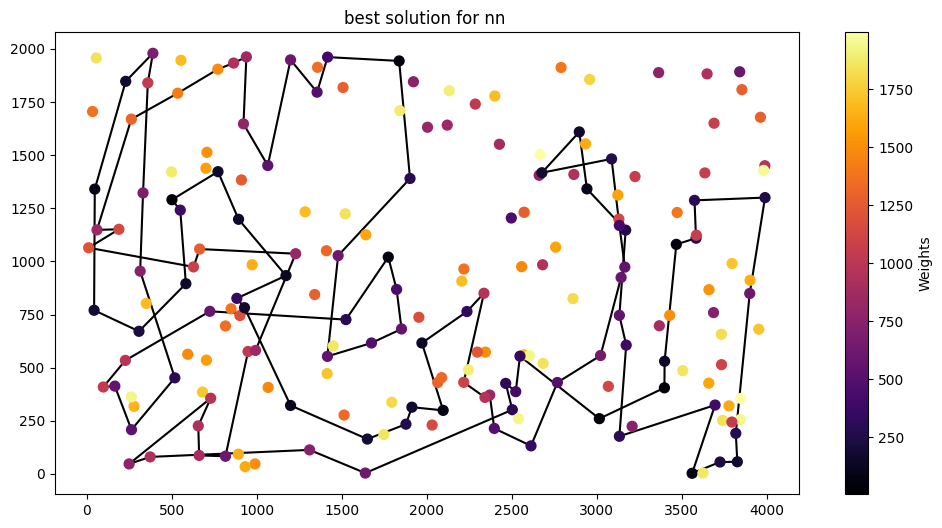

In [401]:
plot_solution(sols_n[scores_n.index(min(scores_n))], coordinates, costs, 'best solution for nn ')

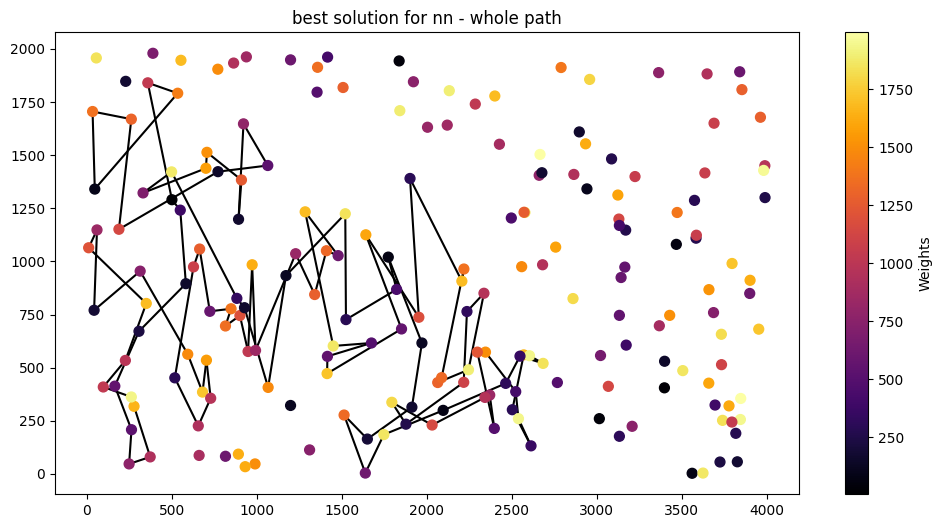

In [405]:
plot_solution(sols_w[scores_w.index(min(scores_w))], coordinates, costs, 'best solution for nn - whole path')

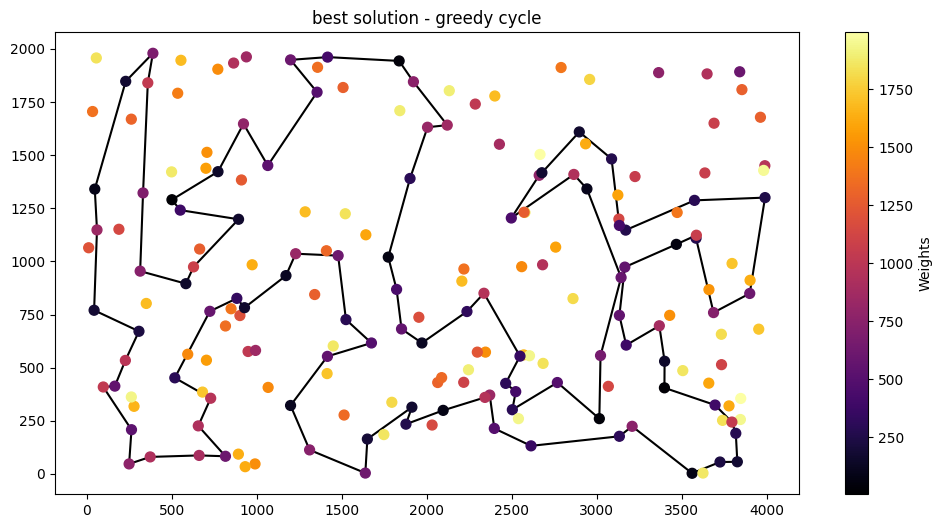

In [395]:
plot_solution(sols_c[scores_c.index(min(scores_c))], coordinates, costs, 'best solution - greedy cycle')

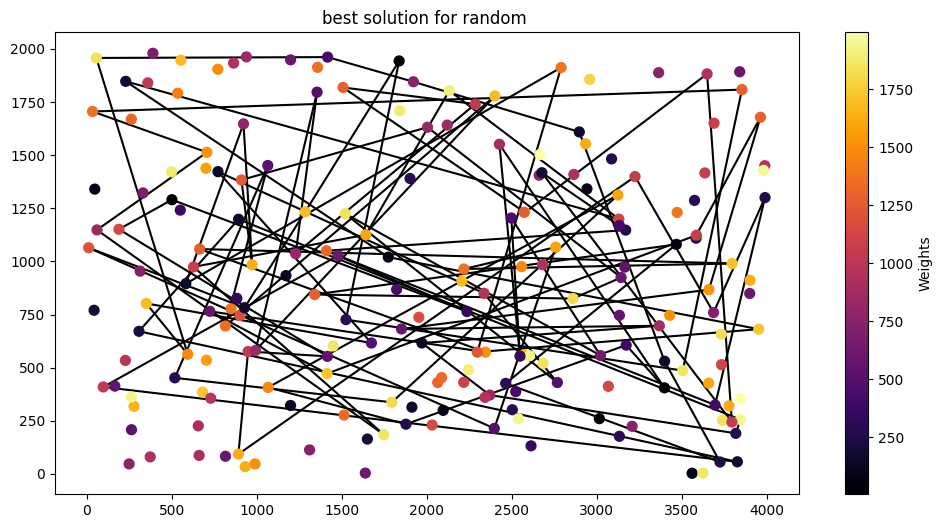

In [396]:
plot_solution(sols_r[scores_r.index(min(scores_r))], coordinates, costs, 'best solution for random ')

In [346]:
sol_w=np.array(sols_w[scores_w.index(min(scores_w))])
pd.DataFrame(sol_w).to_csv('sol_w.csv', header=False, index=False)

In [347]:
sol_n=np.array(sols_n[scores_n.index(min(scores_n))])
pd.DataFrame(sol_n).to_csv('sol_n.csv', header=False, index=False)

In [348]:
sol_r=np.array(sols_r[scores_r.index(min(scores_r))])
pd.DataFrame(sol_r).to_csv('sol_r.csv', header=False, index=False)

In [349]:
sol_c=np.array(sols_c[scores_c.index(min(scores_c))])
pd.DataFrame(sol_c).to_csv('sol_c.csv', header=False, index=False)

In [350]:
%%timeit
get_random_solution(200)

11 μs ± 61 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [351]:
%%timeit
nn(0, dist, costs)

15 ms ± 271 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [352]:
%%timeit
nn_whole_path(0, dist, costs)

156 ms ± 3.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [353]:
%%timeit
greedy_cycle(0, dist, costs)

545 ms ± 13.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
